# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("nuclear_charges")
forces[0]

<tf.Tensor: shape=(21, 3), dtype=float64, numpy=
array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52

In [6]:
from kgcnn.data.transform.scaler.force import EnergyForceExtensiveLabelScaler
scaler = EnergyForceExtensiveLabelScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.model.force import EnergyForceModel

In [8]:
model_config = {
    "model_energy":{
        "module_name": "kgcnn.literature.Schnet", 
        "class_name":"make_model", 
        "config":{
            "name": "Schnet",
            "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                       {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                       {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
            "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
            "make_distance": True, "expand_distance": True,
            "interaction_args": {"units": 128, "use_bias": True,
                                 "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
            "node_pooling_args": {"pooling_method": "sum"},
            "depth": 4,
            "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
            "verbose": 10,
            "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                         "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
            "output_embedding": "graph", "output_to_tensor": True,
            "use_output_mlp": True,
            "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                           "activation": ["kgcnn>shifted_softplus", "linear"]}}
    },
    "output_as_dict":True,
    "output_to_tensor":False,
    "output_squeeze_states":True,
}
model = EnergyForceModel(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [9]:
x_tensor = data.tensor(model_config["model_energy"]["config"]["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [10]:
test_out = model.predict(x_tensor)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

16/16 [==============================] - 5s 28ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [12]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": RaggedMeanAbsoluteError()},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights=[1, 20],
)

In [14]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 10s - loss: 18.9675 - energy_loss: 0.2432 - force_loss: 0.9362 - 10s/epoch - 1s/step
Epoch 2/1500
8/8 - 1s - loss: 18.9285 - energy_loss: 0.2114 - force_loss: 0.9359 - 571ms/epoch - 71ms/step
Epoch 3/1500
8/8 - 1s - loss: 18.9187 - energy_loss: 0.2177 - force_loss: 0.9350 - 567ms/epoch - 71ms/step
Epoch 4/1500
8/8 - 1s - loss: 18.8664 - energy_loss: 0.2177 - force_loss: 0.9324 - 572ms/epoch - 71ms/step
Epoch 5/1500
8/8 - 1s - loss: 18.7211 - energy_loss: 0.2712 - force_loss: 0.9225 - 554ms/epoch - 69ms/step
Epoch 6/1500
8/8 - 1s - loss: 18.4109 - energy_loss: 0.3830 - force_loss: 0.9014 - 574ms/epoch - 72ms/step
Epoch 7/1500
8/8 - 1s - loss: 18.4816 - energy_loss: 0.9093 - force_loss: 0.8786 - 541ms/epoch - 68ms/step
Epoch 8/1500
8/8 - 1s - loss: 18.2063 - energy_loss: 0.6557 - force_loss: 0.8775 - 556ms/epoch - 69ms/step
Epoch 9/1500
8/8 - 1s - loss: 17.5217 - energy_loss: 0.7256 - force_loss: 0.8398 - 533ms/epoch - 67ms/step
Epoch 10/1500
8/8 - 1s - loss: 16.7234 - energy_loss:

Epoch 78/1500
8/8 - 1s - loss: 6.5135 - energy_loss: 0.7881 - force_loss: 0.2863 - 539ms/epoch - 67ms/step
Epoch 79/1500
8/8 - 1s - loss: 6.4871 - energy_loss: 0.8113 - force_loss: 0.2838 - 543ms/epoch - 68ms/step
Epoch 80/1500
8/8 - 1s - loss: 6.3791 - energy_loss: 0.7682 - force_loss: 0.2805 - 535ms/epoch - 67ms/step
Epoch 81/1500
8/8 - 1s - loss: 6.3148 - energy_loss: 0.7636 - force_loss: 0.2776 - 533ms/epoch - 67ms/step
Epoch 82/1500
8/8 - 1s - loss: 6.3466 - energy_loss: 0.7849 - force_loss: 0.2781 - 526ms/epoch - 66ms/step
Epoch 83/1500
8/8 - 1s - loss: 6.3984 - energy_loss: 0.8092 - force_loss: 0.2795 - 547ms/epoch - 68ms/step
Epoch 84/1500
8/8 - 1s - loss: 6.4793 - energy_loss: 0.7611 - force_loss: 0.2859 - 550ms/epoch - 69ms/step
Epoch 85/1500
8/8 - 1s - loss: 6.6920 - energy_loss: 0.7934 - force_loss: 0.2949 - 544ms/epoch - 68ms/step
Epoch 86/1500
8/8 - 1s - loss: 6.3498 - energy_loss: 0.7576 - force_loss: 0.2796 - 563ms/epoch - 70ms/step
Epoch 87/1500
8/8 - 1s - loss: 6.1999

8/8 - 1s - loss: 4.4831 - energy_loss: 0.6669 - force_loss: 0.1908 - 552ms/epoch - 69ms/step
Epoch 155/1500
8/8 - 1s - loss: 4.4677 - energy_loss: 0.6604 - force_loss: 0.1904 - 532ms/epoch - 66ms/step
Epoch 156/1500
8/8 - 1s - loss: 4.4928 - energy_loss: 0.6827 - force_loss: 0.1905 - 553ms/epoch - 69ms/step
Epoch 157/1500
8/8 - 1s - loss: 4.4172 - energy_loss: 0.6734 - force_loss: 0.1872 - 549ms/epoch - 69ms/step
Epoch 158/1500
8/8 - 1s - loss: 4.4309 - energy_loss: 0.6703 - force_loss: 0.1880 - 544ms/epoch - 68ms/step
Epoch 159/1500
8/8 - 1s - loss: 4.4032 - energy_loss: 0.5891 - force_loss: 0.1907 - 548ms/epoch - 69ms/step
Epoch 160/1500
8/8 - 1s - loss: 4.5649 - energy_loss: 0.7410 - force_loss: 0.1912 - 556ms/epoch - 70ms/step
Epoch 161/1500
8/8 - 1s - loss: 4.3838 - energy_loss: 0.5426 - force_loss: 0.1921 - 573ms/epoch - 72ms/step
Epoch 162/1500
8/8 - 1s - loss: 4.4375 - energy_loss: 0.5850 - force_loss: 0.1926 - 555ms/epoch - 69ms/step
Epoch 163/1500
8/8 - 1s - loss: 4.5247 - en

Epoch 230/1500
8/8 - 1s - loss: 4.7113 - energy_loss: 1.3987 - force_loss: 0.1656 - 542ms/epoch - 68ms/step
Epoch 231/1500
8/8 - 1s - loss: 4.7475 - energy_loss: 1.2725 - force_loss: 0.1738 - 534ms/epoch - 67ms/step
Epoch 232/1500
8/8 - 1s - loss: 4.6563 - energy_loss: 0.8101 - force_loss: 0.1923 - 548ms/epoch - 68ms/step
Epoch 233/1500
8/8 - 1s - loss: 4.3535 - energy_loss: 0.9153 - force_loss: 0.1719 - 539ms/epoch - 67ms/step
Epoch 234/1500
8/8 - 1s - loss: 3.5093 - energy_loss: 0.2794 - force_loss: 0.1615 - 536ms/epoch - 67ms/step
Epoch 235/1500
8/8 - 1s - loss: 3.3553 - energy_loss: 0.2291 - force_loss: 0.1563 - 565ms/epoch - 71ms/step
Epoch 236/1500
8/8 - 1s - loss: 3.3501 - energy_loss: 0.3067 - force_loss: 0.1522 - 546ms/epoch - 68ms/step
Epoch 237/1500
8/8 - 1s - loss: 3.7008 - energy_loss: 0.5513 - force_loss: 0.1575 - 541ms/epoch - 68ms/step
Epoch 238/1500
8/8 - 1s - loss: 3.8276 - energy_loss: 0.5176 - force_loss: 0.1655 - 531ms/epoch - 66ms/step
Epoch 239/1500
8/8 - 1s - lo

Epoch 306/1500
8/8 - 1s - loss: 3.2723 - energy_loss: 0.5157 - force_loss: 0.1378 - 607ms/epoch - 76ms/step
Epoch 307/1500
8/8 - 1s - loss: 3.2856 - energy_loss: 0.4813 - force_loss: 0.1402 - 547ms/epoch - 68ms/step
Epoch 308/1500
8/8 - 1s - loss: 3.3733 - energy_loss: 0.5088 - force_loss: 0.1432 - 547ms/epoch - 68ms/step
Epoch 309/1500
8/8 - 1s - loss: 3.3120 - energy_loss: 0.5135 - force_loss: 0.1399 - 557ms/epoch - 70ms/step
Epoch 310/1500
8/8 - 1s - loss: 3.2480 - energy_loss: 0.4913 - force_loss: 0.1378 - 543ms/epoch - 68ms/step
Epoch 311/1500
8/8 - 1s - loss: 3.2178 - energy_loss: 0.4791 - force_loss: 0.1369 - 550ms/epoch - 69ms/step
Epoch 312/1500
8/8 - 1s - loss: 3.2595 - energy_loss: 0.4809 - force_loss: 0.1389 - 545ms/epoch - 68ms/step
Epoch 313/1500
8/8 - 1s - loss: 3.2335 - energy_loss: 0.5621 - force_loss: 0.1336 - 563ms/epoch - 70ms/step
Epoch 314/1500
8/8 - 1s - loss: 2.9675 - energy_loss: 0.2624 - force_loss: 0.1353 - 531ms/epoch - 66ms/step
Epoch 315/1500
8/8 - 1s - lo

Epoch 382/1500
8/8 - 1s - loss: 3.5718 - energy_loss: 0.5241 - force_loss: 0.1524 - 606ms/epoch - 76ms/step
Epoch 383/1500
8/8 - 1s - loss: 3.3831 - energy_loss: 0.4646 - force_loss: 0.1459 - 610ms/epoch - 76ms/step
Epoch 384/1500
8/8 - 1s - loss: 3.0301 - energy_loss: 0.4207 - force_loss: 0.1305 - 631ms/epoch - 79ms/step
Epoch 385/1500
8/8 - 1s - loss: 3.1765 - energy_loss: 0.5057 - force_loss: 0.1335 - 619ms/epoch - 77ms/step
Epoch 386/1500
8/8 - 1s - loss: 2.8243 - energy_loss: 0.1871 - force_loss: 0.1319 - 607ms/epoch - 76ms/step
Epoch 387/1500
8/8 - 1s - loss: 2.7967 - energy_loss: 0.1804 - force_loss: 0.1308 - 610ms/epoch - 76ms/step
Epoch 388/1500
8/8 - 1s - loss: 2.7268 - energy_loss: 0.2215 - force_loss: 0.1253 - 610ms/epoch - 76ms/step
Epoch 389/1500
8/8 - 1s - loss: 2.6265 - energy_loss: 0.2099 - force_loss: 0.1208 - 602ms/epoch - 75ms/step
Epoch 390/1500
8/8 - 1s - loss: 2.9144 - energy_loss: 0.4836 - force_loss: 0.1215 - 593ms/epoch - 74ms/step
Epoch 391/1500
8/8 - 1s - lo

Epoch 458/1500
8/8 - 1s - loss: 2.9731 - energy_loss: 0.4683 - force_loss: 0.1252 - 539ms/epoch - 67ms/step
Epoch 459/1500
8/8 - 1s - loss: 2.9191 - energy_loss: 0.4171 - force_loss: 0.1251 - 539ms/epoch - 67ms/step
Epoch 460/1500
8/8 - 1s - loss: 2.8611 - energy_loss: 0.4523 - force_loss: 0.1204 - 533ms/epoch - 67ms/step
Epoch 461/1500
8/8 - 1s - loss: 2.7462 - energy_loss: 0.4381 - force_loss: 0.1154 - 533ms/epoch - 67ms/step
Epoch 462/1500
8/8 - 1s - loss: 2.9510 - energy_loss: 0.4089 - force_loss: 0.1271 - 532ms/epoch - 66ms/step
Epoch 463/1500
8/8 - 1s - loss: 3.1614 - energy_loss: 0.4376 - force_loss: 0.1362 - 554ms/epoch - 69ms/step
Epoch 464/1500
8/8 - 1s - loss: 3.1194 - energy_loss: 0.4559 - force_loss: 0.1332 - 538ms/epoch - 67ms/step
Epoch 465/1500
8/8 - 1s - loss: 3.1085 - energy_loss: 0.4968 - force_loss: 0.1306 - 531ms/epoch - 66ms/step
Epoch 466/1500
8/8 - 1s - loss: 2.8360 - energy_loss: 0.4339 - force_loss: 0.1201 - 543ms/epoch - 68ms/step
Epoch 467/1500
8/8 - 1s - lo

Epoch 534/1500
8/8 - 1s - loss: 2.2689 - energy_loss: 0.1797 - force_loss: 0.1045 - 542ms/epoch - 68ms/step
Epoch 535/1500
8/8 - 1s - loss: 2.5217 - energy_loss: 0.3934 - force_loss: 0.1064 - 548ms/epoch - 68ms/step
Epoch 536/1500
8/8 - 1s - loss: 2.5182 - energy_loss: 0.3514 - force_loss: 0.1083 - 533ms/epoch - 67ms/step
Epoch 537/1500
8/8 - 1s - loss: 2.7329 - energy_loss: 0.3935 - force_loss: 0.1170 - 530ms/epoch - 66ms/step
Epoch 538/1500
8/8 - 1s - loss: 2.6431 - energy_loss: 0.4319 - force_loss: 0.1106 - 529ms/epoch - 66ms/step
Epoch 539/1500
8/8 - 1s - loss: 2.5213 - energy_loss: 0.3837 - force_loss: 0.1069 - 533ms/epoch - 67ms/step
Epoch 540/1500
8/8 - 1s - loss: 2.5065 - energy_loss: 0.4062 - force_loss: 0.1050 - 540ms/epoch - 68ms/step
Epoch 541/1500
8/8 - 1s - loss: 2.5151 - energy_loss: 0.4000 - force_loss: 0.1058 - 537ms/epoch - 67ms/step
Epoch 542/1500
8/8 - 1s - loss: 2.5685 - energy_loss: 0.4148 - force_loss: 0.1077 - 597ms/epoch - 75ms/step
Epoch 543/1500
8/8 - 1s - lo

Epoch 610/1500
8/8 - 1s - loss: 2.4699 - energy_loss: 0.4562 - force_loss: 0.1007 - 561ms/epoch - 70ms/step
Epoch 611/1500
8/8 - 1s - loss: 2.2778 - energy_loss: 0.3072 - force_loss: 0.0985 - 540ms/epoch - 68ms/step
Epoch 612/1500
8/8 - 1s - loss: 2.1251 - energy_loss: 0.1704 - force_loss: 0.0977 - 542ms/epoch - 68ms/step
Epoch 613/1500
8/8 - 1s - loss: 2.2817 - energy_loss: 0.3722 - force_loss: 0.0955 - 561ms/epoch - 70ms/step
Epoch 614/1500
8/8 - 1s - loss: 2.3023 - energy_loss: 0.4024 - force_loss: 0.0950 - 544ms/epoch - 68ms/step
Epoch 615/1500
8/8 - 1s - loss: 2.3450 - energy_loss: 0.3969 - force_loss: 0.0974 - 548ms/epoch - 68ms/step
Epoch 616/1500
8/8 - 1s - loss: 2.3924 - energy_loss: 0.3998 - force_loss: 0.0996 - 547ms/epoch - 68ms/step
Epoch 617/1500
8/8 - 1s - loss: 2.3741 - energy_loss: 0.3597 - force_loss: 0.1007 - 546ms/epoch - 68ms/step
Epoch 618/1500
8/8 - 1s - loss: 2.4072 - energy_loss: 0.3929 - force_loss: 0.1007 - 531ms/epoch - 66ms/step
Epoch 619/1500
8/8 - 1s - lo

Epoch 686/1500
8/8 - 1s - loss: 2.4022 - energy_loss: 0.3866 - force_loss: 0.1008 - 546ms/epoch - 68ms/step
Epoch 687/1500
8/8 - 1s - loss: 2.2846 - energy_loss: 0.2123 - force_loss: 0.1036 - 533ms/epoch - 67ms/step
Epoch 688/1500
8/8 - 1s - loss: 2.2069 - energy_loss: 0.3536 - force_loss: 0.0927 - 541ms/epoch - 68ms/step
Epoch 689/1500
8/8 - 1s - loss: 2.3430 - energy_loss: 0.3760 - force_loss: 0.0984 - 542ms/epoch - 68ms/step
Epoch 690/1500
8/8 - 1s - loss: 2.3442 - energy_loss: 0.3746 - force_loss: 0.0985 - 541ms/epoch - 68ms/step
Epoch 691/1500
8/8 - 1s - loss: 2.1052 - energy_loss: 0.1897 - force_loss: 0.0958 - 537ms/epoch - 67ms/step
Epoch 692/1500
8/8 - 1s - loss: 2.0044 - energy_loss: 0.1630 - force_loss: 0.0921 - 532ms/epoch - 66ms/step
Epoch 693/1500
8/8 - 1s - loss: 1.9364 - energy_loss: 0.1562 - force_loss: 0.0890 - 531ms/epoch - 66ms/step
Epoch 694/1500
8/8 - 1s - loss: 1.9620 - energy_loss: 0.1805 - force_loss: 0.0891 - 533ms/epoch - 67ms/step
Epoch 695/1500
8/8 - 1s - lo

Epoch 762/1500
8/8 - 1s - loss: 1.9960 - energy_loss: 0.2203 - force_loss: 0.0888 - 532ms/epoch - 67ms/step
Epoch 763/1500
8/8 - 1s - loss: 1.9140 - energy_loss: 0.1743 - force_loss: 0.0870 - 535ms/epoch - 67ms/step
Epoch 764/1500
8/8 - 1s - loss: 1.9309 - energy_loss: 0.1887 - force_loss: 0.0871 - 546ms/epoch - 68ms/step
Epoch 765/1500
8/8 - 1s - loss: 2.2695 - energy_loss: 0.4724 - force_loss: 0.0899 - 534ms/epoch - 67ms/step
Epoch 766/1500
8/8 - 1s - loss: 2.2439 - energy_loss: 0.3487 - force_loss: 0.0948 - 534ms/epoch - 67ms/step
Epoch 767/1500
8/8 - 1s - loss: 2.0341 - energy_loss: 0.1735 - force_loss: 0.0930 - 543ms/epoch - 68ms/step
Epoch 768/1500
8/8 - 1s - loss: 2.2129 - energy_loss: 0.3968 - force_loss: 0.0908 - 538ms/epoch - 67ms/step
Epoch 769/1500
8/8 - 1s - loss: 2.0076 - energy_loss: 0.1909 - force_loss: 0.0908 - 571ms/epoch - 71ms/step
Epoch 770/1500
8/8 - 1s - loss: 1.8882 - energy_loss: 0.1668 - force_loss: 0.0861 - 572ms/epoch - 72ms/step
Epoch 771/1500
8/8 - 1s - lo

Epoch 838/1500
8/8 - 1s - loss: 2.2256 - energy_loss: 0.3749 - force_loss: 0.0925 - 531ms/epoch - 66ms/step
Epoch 839/1500
8/8 - 1s - loss: 2.2657 - energy_loss: 0.4105 - force_loss: 0.0928 - 531ms/epoch - 66ms/step
Epoch 840/1500
8/8 - 1s - loss: 2.1422 - energy_loss: 0.3911 - force_loss: 0.0876 - 530ms/epoch - 66ms/step
Epoch 841/1500
8/8 - 1s - loss: 2.1145 - energy_loss: 0.3375 - force_loss: 0.0889 - 529ms/epoch - 66ms/step
Epoch 842/1500
8/8 - 1s - loss: 2.1778 - energy_loss: 0.4532 - force_loss: 0.0862 - 534ms/epoch - 67ms/step
Epoch 843/1500
8/8 - 1s - loss: 1.8976 - energy_loss: 0.2075 - force_loss: 0.0845 - 537ms/epoch - 67ms/step
Epoch 844/1500
8/8 - 1s - loss: 1.8415 - energy_loss: 0.1836 - force_loss: 0.0829 - 527ms/epoch - 66ms/step
Epoch 845/1500
8/8 - 1s - loss: 1.9958 - energy_loss: 0.3391 - force_loss: 0.0828 - 529ms/epoch - 66ms/step
Epoch 846/1500
8/8 - 1s - loss: 2.0824 - energy_loss: 0.3265 - force_loss: 0.0878 - 531ms/epoch - 66ms/step
Epoch 847/1500
8/8 - 1s - lo

Epoch 914/1500
8/8 - 1s - loss: 2.3578 - energy_loss: 0.6237 - force_loss: 0.0867 - 530ms/epoch - 66ms/step
Epoch 915/1500
8/8 - 1s - loss: 2.4721 - energy_loss: 0.6559 - force_loss: 0.0908 - 531ms/epoch - 66ms/step
Epoch 916/1500
8/8 - 1s - loss: 1.9654 - energy_loss: 0.1449 - force_loss: 0.0910 - 530ms/epoch - 66ms/step
Epoch 917/1500
8/8 - 1s - loss: 1.9872 - energy_loss: 0.3369 - force_loss: 0.0825 - 534ms/epoch - 67ms/step
Epoch 918/1500
8/8 - 1s - loss: 1.8450 - energy_loss: 0.1839 - force_loss: 0.0831 - 533ms/epoch - 67ms/step
Epoch 919/1500
8/8 - 1s - loss: 1.8661 - energy_loss: 0.2133 - force_loss: 0.0826 - 533ms/epoch - 67ms/step
Epoch 920/1500
8/8 - 1s - loss: 2.1749 - energy_loss: 0.4458 - force_loss: 0.0865 - 553ms/epoch - 69ms/step
Epoch 921/1500
8/8 - 1s - loss: 2.1124 - energy_loss: 0.3187 - force_loss: 0.0897 - 530ms/epoch - 66ms/step
Epoch 922/1500
8/8 - 1s - loss: 1.9642 - energy_loss: 0.1612 - force_loss: 0.0901 - 530ms/epoch - 66ms/step
Epoch 923/1500
8/8 - 1s - lo

Epoch 990/1500
8/8 - 1s - loss: 2.1955 - energy_loss: 0.5074 - force_loss: 0.0844 - 528ms/epoch - 66ms/step
Epoch 991/1500
8/8 - 1s - loss: 1.8397 - energy_loss: 0.1814 - force_loss: 0.0829 - 529ms/epoch - 66ms/step
Epoch 992/1500
8/8 - 1s - loss: 1.7444 - energy_loss: 0.1607 - force_loss: 0.0792 - 532ms/epoch - 66ms/step
Epoch 993/1500
8/8 - 1s - loss: 2.1054 - energy_loss: 0.3273 - force_loss: 0.0889 - 530ms/epoch - 66ms/step
Epoch 994/1500
8/8 - 1s - loss: 1.8320 - energy_loss: 0.1813 - force_loss: 0.0825 - 531ms/epoch - 66ms/step
Epoch 995/1500
8/8 - 1s - loss: 2.0903 - energy_loss: 0.3471 - force_loss: 0.0872 - 529ms/epoch - 66ms/step
Epoch 996/1500
8/8 - 1s - loss: 2.0759 - energy_loss: 0.2727 - force_loss: 0.0902 - 530ms/epoch - 66ms/step
Epoch 997/1500
8/8 - 1s - loss: 1.8002 - energy_loss: 0.1631 - force_loss: 0.0819 - 531ms/epoch - 66ms/step
Epoch 998/1500
8/8 - 1s - loss: 1.7158 - energy_loss: 0.1739 - force_loss: 0.0771 - 534ms/epoch - 67ms/step
Epoch 999/1500
8/8 - 1s - lo

Epoch 1066/1500
8/8 - 1s - loss: 1.6485 - energy_loss: 0.1411 - force_loss: 0.0754 - 531ms/epoch - 66ms/step
Epoch 1067/1500
8/8 - 1s - loss: 1.9759 - energy_loss: 0.4566 - force_loss: 0.0760 - 532ms/epoch - 66ms/step
Epoch 1068/1500
8/8 - 1s - loss: 2.4933 - energy_loss: 0.8964 - force_loss: 0.0798 - 529ms/epoch - 66ms/step
Epoch 1069/1500
8/8 - 1s - loss: 2.5477 - energy_loss: 0.9304 - force_loss: 0.0809 - 530ms/epoch - 66ms/step
Epoch 1070/1500
8/8 - 1s - loss: 2.2911 - energy_loss: 0.5310 - force_loss: 0.0880 - 533ms/epoch - 67ms/step
Epoch 1071/1500
8/8 - 1s - loss: 2.4118 - energy_loss: 0.4995 - force_loss: 0.0956 - 530ms/epoch - 66ms/step
Epoch 1072/1500
8/8 - 1s - loss: 2.2547 - energy_loss: 0.2541 - force_loss: 0.1000 - 530ms/epoch - 66ms/step
Epoch 1073/1500
8/8 - 1s - loss: 1.9032 - energy_loss: 0.1542 - force_loss: 0.0874 - 530ms/epoch - 66ms/step
Epoch 1074/1500
8/8 - 1s - loss: 1.7613 - energy_loss: 0.1583 - force_loss: 0.0802 - 528ms/epoch - 66ms/step
Epoch 1075/1500
8/8

Epoch 1142/1500
8/8 - 1s - loss: 1.6941 - energy_loss: 0.2464 - force_loss: 0.0724 - 532ms/epoch - 66ms/step
Epoch 1143/1500
8/8 - 1s - loss: 1.9093 - energy_loss: 0.3340 - force_loss: 0.0788 - 532ms/epoch - 66ms/step
Epoch 1144/1500
8/8 - 1s - loss: 1.8288 - energy_loss: 0.2477 - force_loss: 0.0791 - 530ms/epoch - 66ms/step
Epoch 1145/1500
8/8 - 1s - loss: 1.9212 - energy_loss: 0.3374 - force_loss: 0.0792 - 529ms/epoch - 66ms/step
Epoch 1146/1500
8/8 - 1s - loss: 1.7828 - energy_loss: 0.2937 - force_loss: 0.0745 - 533ms/epoch - 67ms/step
Epoch 1147/1500
8/8 - 1s - loss: 1.6849 - energy_loss: 0.1726 - force_loss: 0.0756 - 530ms/epoch - 66ms/step
Epoch 1148/1500
8/8 - 1s - loss: 1.6603 - energy_loss: 0.1387 - force_loss: 0.0761 - 531ms/epoch - 66ms/step
Epoch 1149/1500
8/8 - 1s - loss: 1.6064 - energy_loss: 0.1365 - force_loss: 0.0735 - 526ms/epoch - 66ms/step
Epoch 1150/1500
8/8 - 1s - loss: 1.6290 - energy_loss: 0.2013 - force_loss: 0.0714 - 533ms/epoch - 67ms/step
Epoch 1151/1500
8/8

Epoch 1218/1500
8/8 - 1s - loss: 1.7156 - energy_loss: 0.3256 - force_loss: 0.0695 - 529ms/epoch - 66ms/step
Epoch 1219/1500
8/8 - 1s - loss: 1.9618 - energy_loss: 0.5706 - force_loss: 0.0696 - 529ms/epoch - 66ms/step
Epoch 1220/1500
8/8 - 1s - loss: 2.0126 - energy_loss: 0.5589 - force_loss: 0.0727 - 532ms/epoch - 66ms/step
Epoch 1221/1500
8/8 - 1s - loss: 2.0739 - energy_loss: 0.5880 - force_loss: 0.0743 - 533ms/epoch - 67ms/step
Epoch 1222/1500
8/8 - 1s - loss: 2.0437 - energy_loss: 0.5347 - force_loss: 0.0754 - 528ms/epoch - 66ms/step
Epoch 1223/1500
8/8 - 1s - loss: 1.9724 - energy_loss: 0.4843 - force_loss: 0.0744 - 530ms/epoch - 66ms/step
Epoch 1224/1500
8/8 - 1s - loss: 1.8406 - energy_loss: 0.2955 - force_loss: 0.0773 - 529ms/epoch - 66ms/step
Epoch 1225/1500
8/8 - 1s - loss: 2.2875 - energy_loss: 0.6117 - force_loss: 0.0838 - 532ms/epoch - 67ms/step
Epoch 1226/1500
8/8 - 1s - loss: 1.9558 - energy_loss: 0.2502 - force_loss: 0.0853 - 536ms/epoch - 67ms/step
Epoch 1227/1500
8/8

Epoch 1294/1500
8/8 - 1s - loss: 1.6841 - energy_loss: 0.1855 - force_loss: 0.0749 - 566ms/epoch - 71ms/step
Epoch 1295/1500
8/8 - 1s - loss: 1.7369 - energy_loss: 0.2671 - force_loss: 0.0735 - 546ms/epoch - 68ms/step
Epoch 1296/1500
8/8 - 1s - loss: 1.6752 - energy_loss: 0.1354 - force_loss: 0.0770 - 535ms/epoch - 67ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.5851 - energy_loss: 0.1495 - force_loss: 0.0718 - 530ms/epoch - 66ms/step
Epoch 1298/1500
8/8 - 1s - loss: 1.8554 - energy_loss: 0.4601 - force_loss: 0.0698 - 531ms/epoch - 66ms/step
Epoch 1299/1500
8/8 - 1s - loss: 1.8787 - energy_loss: 0.3982 - force_loss: 0.0740 - 531ms/epoch - 66ms/step
Epoch 1300/1500
8/8 - 1s - loss: 1.7569 - energy_loss: 0.2483 - force_loss: 0.0754 - 536ms/epoch - 67ms/step
Epoch 1301/1500
8/8 - 1s - loss: 2.0826 - energy_loss: 0.4873 - force_loss: 0.0798 - 534ms/epoch - 67ms/step
Epoch 1302/1500
8/8 - 1s - loss: 2.0539 - energy_loss: 0.5344 - force_loss: 0.0760 - 531ms/epoch - 66ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 1.7293 - energy_loss: 0.2027 - force_loss: 0.0763 - 551ms/epoch - 69ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.4981 - energy_loss: 0.1318 - force_loss: 0.0683 - 552ms/epoch - 69ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.7123 - energy_loss: 0.2588 - force_loss: 0.0727 - 559ms/epoch - 70ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.4955 - energy_loss: 0.1292 - force_loss: 0.0683 - 546ms/epoch - 68ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.6321 - energy_loss: 0.2749 - force_loss: 0.0679 - 542ms/epoch - 68ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.7446 - energy_loss: 0.2514 - force_loss: 0.0747 - 567ms/epoch - 71ms/step
Epoch 1376/1500
8/8 - 1s - loss: 1.9928 - energy_loss: 0.3582 - force_loss: 0.0817 - 556ms/epoch - 70ms/step
Epoch 1377/1500
8/8 - 1s - loss: 1.6028 - energy_loss: 0.1198 - force_loss: 0.0742 - 566ms/epoch - 71ms/step
Epoch 1378/1500
8/8 - 1s - loss: 1.5072 - energy_loss: 0.1480 - force_loss: 0.0680 - 550ms/epoch - 69ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.6007 - energy_loss: 0.2017 - force_loss: 0.0699 - 546ms/epoch - 68ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.7396 - energy_loss: 0.2963 - force_loss: 0.0722 - 537ms/epoch - 67ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.7895 - energy_loss: 0.3250 - force_loss: 0.0732 - 562ms/epoch - 70ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.7603 - energy_loss: 0.3156 - force_loss: 0.0722 - 571ms/epoch - 71ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.7723 - energy_loss: 0.2682 - force_loss: 0.0752 - 537ms/epoch - 67ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.9301 - energy_loss: 0.2673 - force_loss: 0.0831 - 546ms/epoch - 68ms/step
Epoch 1452/1500
8/8 - 1s - loss: 2.0918 - energy_loss: 0.4983 - force_loss: 0.0797 - 539ms/epoch - 67ms/step
Epoch 1453/1500
8/8 - 1s - loss: 2.0368 - energy_loss: 0.5590 - force_loss: 0.0739 - 539ms/epoch - 67ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.9863 - energy_loss: 0.5340 - force_loss: 0.0726 - 589ms/epoch - 74ms/step
Epoch 1455/1500
8/8

In [15]:
from kgcnn.utils.plots import plot_train_test_loss

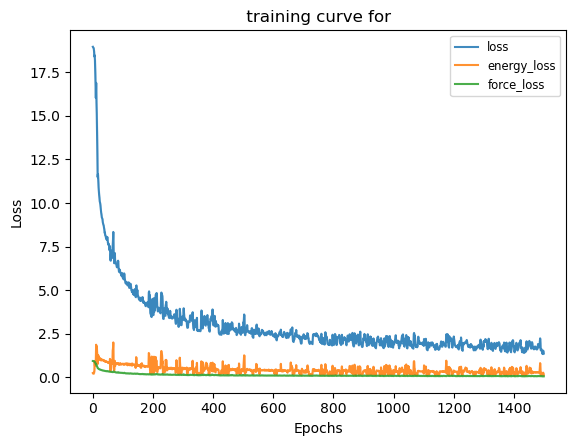

In [16]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [17]:
from kgcnn.molecule.dynamics.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange

In [18]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["model_energy"]["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[SetRange(node_coordinates="coords", overwrite=False)],  # To use 
    graph_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, energy="energy", force="forces", atomic_number="nuclear_charges")],
    store_last_input=True,
    update_from_last_input=["range_indices"],  # and "range_images" if periodic.
    update_from_last_input_skip=3    
)

In [19]:
dyn_model(dataset[0:510])[0]

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

{'energy': array([-17469.87971897]),
 'forces': array([[-2.6926582 ,  2.5945697 , -0.7922855 ],
        [-0.9549633 , -0.8536123 ,  2.01824   ],
        [ 3.0976918 , -2.1983285 , -0.17354974],
        [-0.44424915,  1.7244709 , -0.12942111],
        [ 0.02339101,  1.860508  ,  0.92799246],
        [-0.5627135 ,  0.276788  , -0.10155404],
        [ 0.27722457,  0.67360514, -2.1610928 ],
        [-0.31315768, -1.2103214 , -0.06026554],
        [ 0.55226153,  3.8888586 ,  2.0615144 ],
        [-0.709671  ,  2.0541844 ,  0.69057053],
        [ 1.1678188 , -1.2067232 ,  0.52173024],
        [ 0.5865756 , -3.9474804 , -2.0575016 ],
        [ 1.781745  , -0.86151767, -0.6316459 ],
        [-0.28654134, -0.64994967,  0.49502593],
        [ 1.1596729 , -1.820015  ,  1.3223209 ],
        [ 0.07863323,  0.32028094, -0.86060643],
        [-1.1209358 ,  0.3845262 , -0.16428019],
        [-0.4303491 ,  0.41782677, -0.18890905],
        [-0.26383778, -1.0806571 , -0.7084186 ],
        [-0.44839218, 

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [20]:
from ase import Atoms
from kgcnn.molecule.dynamics.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [21]:
atoms = Atoms(dataset[0]["nuclear_charges"], positions=dataset[0]["coords"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [22]:
conv=AtomsToGraphConverter({"nuclear_charges": "get_atomic_numbers", "coords": "get_positions"})
conv(atoms)

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 2.15275078, -0.93790121, -0.05378575],
       [ 0.99956719,  1.13262738, -1.67300307],
       [ 2.73218273, -0.44859684, -1.19275553],
       [ 2.14794307,  0.41880283, -2.08405233],
       [-3.15705489,  1.42240939,  0.33067654],
       [ 0.91168856, -0.33727827,  0.29772754],
       [ 0.36105629,  0.72618343, -0.42339745],
       [-0.40166094, -0.12259909,  2.26219435],
       [-2.13128849, -0.48888369, -0.80224462],
       [ 0.29867456, -2.24990948,  1.44246368],
       [ 0.1239993 , -0.83296539,  1.42230211],
       [-2.04596577,  0.64616435, -0.22107209],
       [-0.88096468,  1.36265193, -0.06099633],
       [-0.02472582, -2.46371902,  2.33402192],
       [ 2.47956412, -1.70739289,  0.55101985],
       [ 0.49126967,  1.99943374, -2.09234064],
       [ 3.77819263, -0.85891833, -1.40897491],
       [ 2.75656656,  0.58901616, -2.98423316],
       [-2.82095

In [23]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [24]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [25]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

{'energy': array(-17469.87971901), 'forces': array([[-2.6926568 ,  2.5945697 , -0.79228616],
       [-0.9549637 , -0.85361326,  2.018241  ],
       [ 3.0976913 , -2.198329  , -0.17354989],
       [-0.4442494 ,  1.7244716 , -0.1294223 ],
       [ 0.02339014,  1.8605075 ,  0.92799234],
       [-0.5627133 ,  0.27678764, -0.1015538 ],
       [ 0.27722558,  0.6736051 , -2.1610937 ],
       [-0.31315765, -1.2103211 , -0.06026632],
       [ 0.55226177,  3.8888595 ,  2.0615146 ],
       [-0.70967096,  2.0541854 ,  0.69057006],
       [ 1.1678181 , -1.2067242 ,  0.52173096],
       [ 0.58657557, -3.9474814 , -2.0575016 ],
       [ 1.781745  , -0.86151737, -0.63164604],
       [-0.28654146, -0.6499499 ,  0.49502647],
       [ 1.1596727 , -1.8200146 ,  1.3223209 ],
       [ 0.07863363,  0.32028064, -0.86060625],
       [-1.120936  ,  0.38452622, -0.16428   ],
       [-0.43034968,  0.41782665, -0.18890789],
       [-0.26383755, -1.0806569 , -0.70841825],
       [-0.44839206,  0.29148802, -0.559284

In [26]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.899eV  Ekin = 0.027eV (T=206K)  Etot = -831.872eV
Energy per atom: Epot = -831.920eV  Ekin = 0.048eV (T=368K)  Etot = -831.872eV
Energy per atom: Epot = -831.917eV  Ekin = 0.046eV (T=354K)  Etot = -831.871eV
Energy per atom: Epot = -831.913eV  Ekin = 0.041eV (T=319K)  Etot = -831.872eV
Energy per atom: Epot = -831.906eV  Ekin = 0.044eV (T=340K)  Etot = -831.862eV
Energy per atom: Epot = -831.918eV  Ekin = 0.049eV (T=376K)  Etot = -831.870eV
Energy per atom: Epot = -831.906eV  Ekin = 0.036eV (T=282K)  Etot = -831.870eV
Energy per atom: Epot = -831.926eV  Ekin = 0.054eV (T=416K)  Etot = -831.872eV
Energy per atom: Epot = -831.910eV  Ekin = 0.046eV (T=356K)  Etot = -831.864eV
Energy per atom: Epot = -831.906eV  Ekin = 0.044eV (T=337K)  Etot = -831.862eV
Energy per atom: Epot = -831.923eV  Ekin = 0.055eV (T=424K)  Etot = -831.869eV
Energy per atom: Epot = -831.919eV  Ekin = 0.050eV (T=388K)  Etot = -831.869eV
Energy per atom: Epot = -831.914eV  Ekin = 0.042eV (

In [27]:
calc.model_predictor._last_input;

In [28]:
dyn_model._test_timing(conv(atoms))

0.05859375